## Applying the XGBoost algorithm ##

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [75]:
import pandas as pd
import numpy as np

# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import StandardScaler # needed?
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.pipeline import Pipeline
# import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# for reading files
import glob
import os
from datetime import datetime
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [76]:
# input dataset
input_file = "./drive/My Drive/remote_communities/data/all_combined_training.csv"
validation_file = "./drive/My Drive/remote_communities/data/all_combined_validation.csv"
# TODO: XGBoost parameters

In [77]:
# load data
df = pd.read_csv(input_file, index_col = 0)
dfc=df.copy()

In [78]:
dfc.tail(3) 
# dfc['year'].unique()

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C)
236518,2015,12,31,21,365.311750,60.01732,-70.02754,567,582.943444,-19.845023
236519,2015,12,31,22,361.482583,60.01732,-70.02754,567,582.943444,-20.679938
236520,2015,12,31,23,358.839000,60.01732,-70.02754,567,582.943444,-21.149695


In [79]:
dfc['date'] = pd.to_datetime(dfc[['year', 'month', 'day']])
# dfc.keys(), df.keys()
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),date
69811,2014,12,20,19,1136.166,62.20071,-75.65000,1483,1347.844242,-15.260352,2014-12-20
154212,2015,8,9,12,238.900,62.41657,-77.91644,414,384.150178,7.974268,2015-08-09


In [80]:
dfc.rename(columns={"Temp (°C)":"Temp"}, inplace=True)
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp,date
53052,2013,1,21,12,1150.567833,62.20071,-75.65000,1483,1347.844242,-38.510580,2013-01-21
139819,2013,12,17,19,286.367500,62.41657,-77.91644,414,384.150178,-16.294043,2013-12-17


## Power consumption per capita

In [81]:
print(dfc['date'][236520])
dfc['date'][236520].weekday()

2015-12-31 00:00:00


3

In [82]:
dfc ['weekday'] = dfc['date'].dt.weekday

In [83]:
dfc.head()

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp,date,weekday
0,2013,1,1,0,1314.522302,55.27987,-77.75458,686,1984.209328,-16.415625,2013-01-01,1
1,2013,1,1,1,1295.379198,55.27987,-77.75458,686,1984.209328,-17.082617,2013-01-01,1
2,2013,1,1,2,1281.408115,55.27987,-77.75458,686,1984.209328,-16.936621,2013-01-01,1
3,2013,1,1,3,1229.595401,55.27987,-77.75458,686,1984.209328,-17.152701,2013-01-01,1
4,2013,1,1,4,1184.894563,55.27987,-77.75458,686,1984.209328,-17.600867,2013-01-01,1


In [84]:
dfc['Kw_per_capita'] = dfc['Kw']/df['population']


In [85]:
dfc.drop(['Kw', 'population', 'annual_peak_load','year','month','day','lon'],
         axis = 1, inplace = True)
# I am maintaining lat, Kw_per_capita, date, temp, weekday_name and hour features
dfc.tail()

,hour,lat,Temp,date,weekday,Kw_per_capita
236516,19,60.01732,-19.957297,2015-12-31,3,0.640062
236517,20,60.01732,-20.051184,2015-12-31,3,0.648297
236518,21,60.01732,-19.845023,2015-12-31,3,0.644289
236519,22,60.01732,-20.679938,2015-12-31,3,0.637535
236520,23,60.01732,-21.149695,2015-12-31,3,0.632873


## Data by location: creates 9 dataframes df1...df9 to hold info for the 9 locations

In [86]:
# type(dfc['lat'].value_counts())
# dfc['lat'].value_counts().keys()
dfc['lat'].value_counts()

58.45424    26280
62.20071    26280
61.03000    26280
59.31042    26280
62.41657    26280
58.10006    26280
60.01732    26280
55.27987    26232
58.68000    26232
Name: lat, dtype: int64

In [87]:
# create a list of dataframe names
s=[]
for i in range(9):
    s.append('df'+str(i+1))
# print(s)

i=0
for key in dfc['lat'].value_counts().keys():
#     print(key)
    s[i]=dfc[dfc['lat']==key]
#     print(name.head(2))
#     print('\n')
    i=i+1


In [88]:
# s[0] is df1, s[1] is df2, .........
s[0].sample(5)

,hour,lat,Temp,date,weekday,Kw_per_capita
52555,19,58.45424,-13.426123,2015-12-31,3,0.741177
44639,23,58.45424,-25.855597,2015-02-04,2,0.778696
32520,0,58.45424,1.647363,2013-09-18,2,0.510117
30403,19,58.45424,4.172754,2013-06-21,4,0.546810
31130,2,58.45424,5.865625,2013-07-22,0,0.397103


### Aggregate the data by date, which means sum up all the hourly consumptions

Commenting the following aggregation to maintain hourly resolution

In [89]:
# df1=s[0].groupby('date')['Kw_per_capita'].sum().reset_index()
df1=s[0].sort_values(by=['date','hour'])
df1 = df1.reset_index()
# df1['date'].value_counts()
df1.head(10)

,index,hour,lat,Temp,date,weekday,Kw_per_capita
0,26280,0,58.45424,-18.211905,2013-01-01,1,0.586101
1,26281,1,58.45424,-18.678336,2013-01-01,1,0.579210
2,26282,2,58.45424,-18.978430,2013-01-01,1,0.562302
3,26283,3,58.45424,-18.901541,2013-01-01,1,0.555865
4,26284,4,58.45424,-19.094290,2013-01-01,1,0.544718
5,26285,5,58.45424,-18.904410,2013-01-01,1,0.541424
6,26286,6,58.45424,-19.061163,2013-01-01,1,0.535962
7,26287,7,58.45424,-19.123877,2013-01-01,1,0.557908
8,26288,8,58.45424,-19.240210,2013-01-01,1,0.560035
9,26289,9,58.45424,-19.228918,2013-01-01,1,0.556101


In [90]:
df1['index_number'] = list(df1.index)
df1.head()

,index,hour,lat,Temp,date,weekday,Kw_per_capita,index_number
0,26280,0,58.45424,-18.211905,2013-01-01,1,0.586101,0
1,26281,1,58.45424,-18.678336,2013-01-01,1,0.579210,1
2,26282,2,58.45424,-18.978430,2013-01-01,1,0.562302,2
3,26283,3,58.45424,-18.901541,2013-01-01,1,0.555865,3
4,26284,4,58.45424,-19.094290,2013-01-01,1,0.544718,4


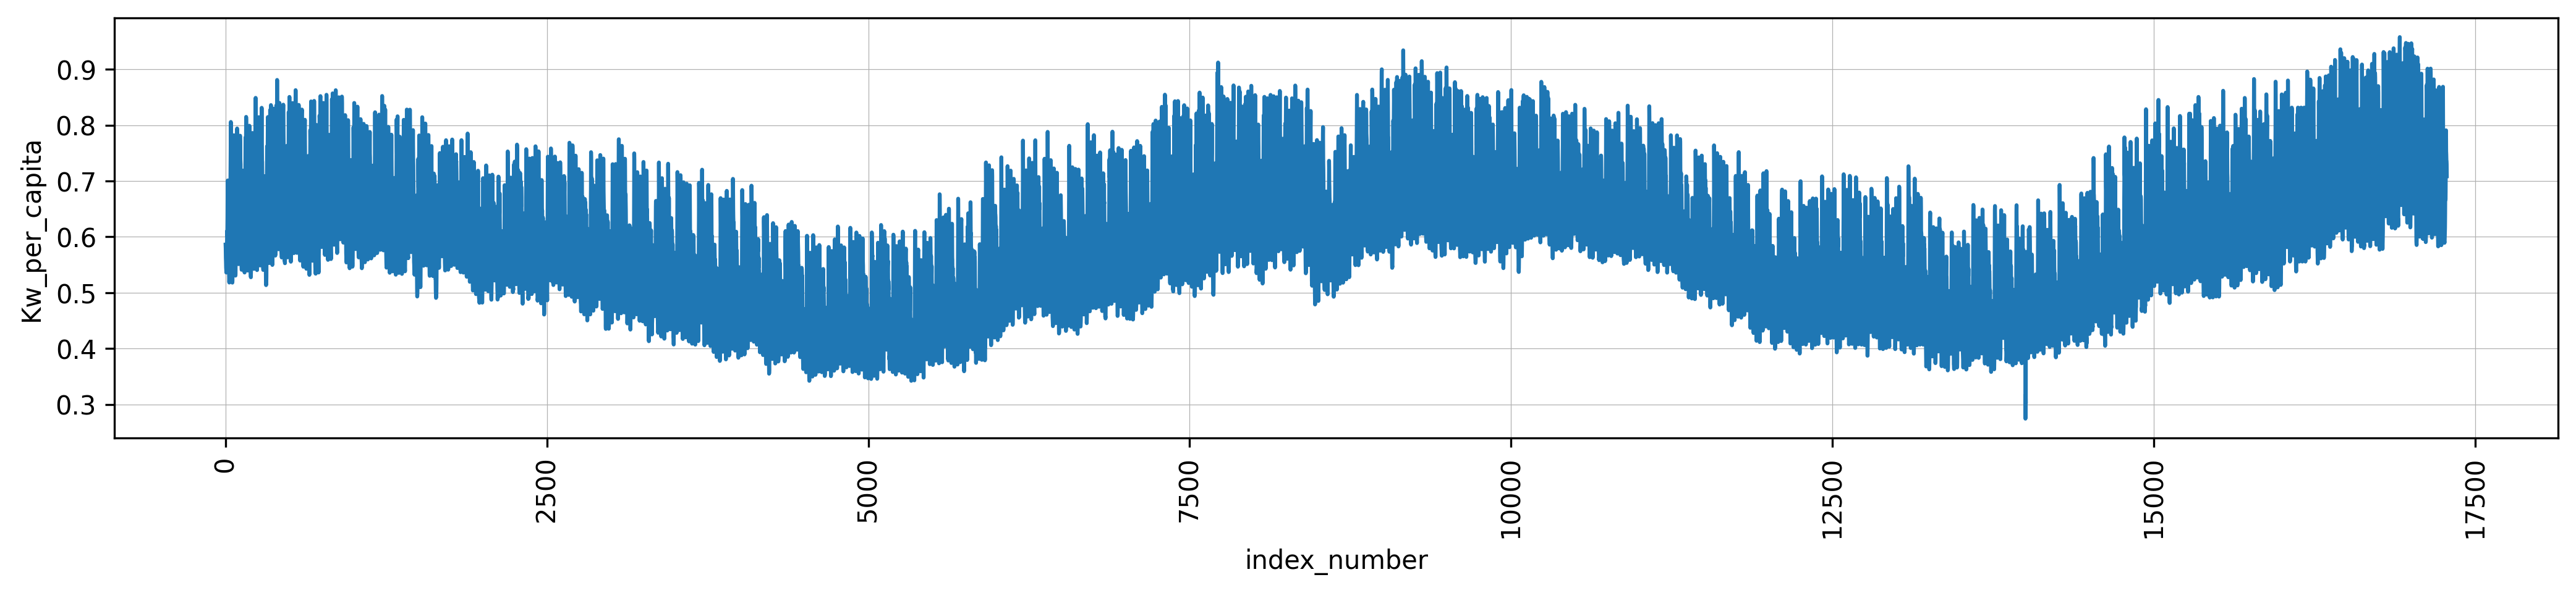

In [91]:
# plot time series
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df1.head(17280), x= 'index_number', y='Kw_per_capita')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
# dfc.keys()

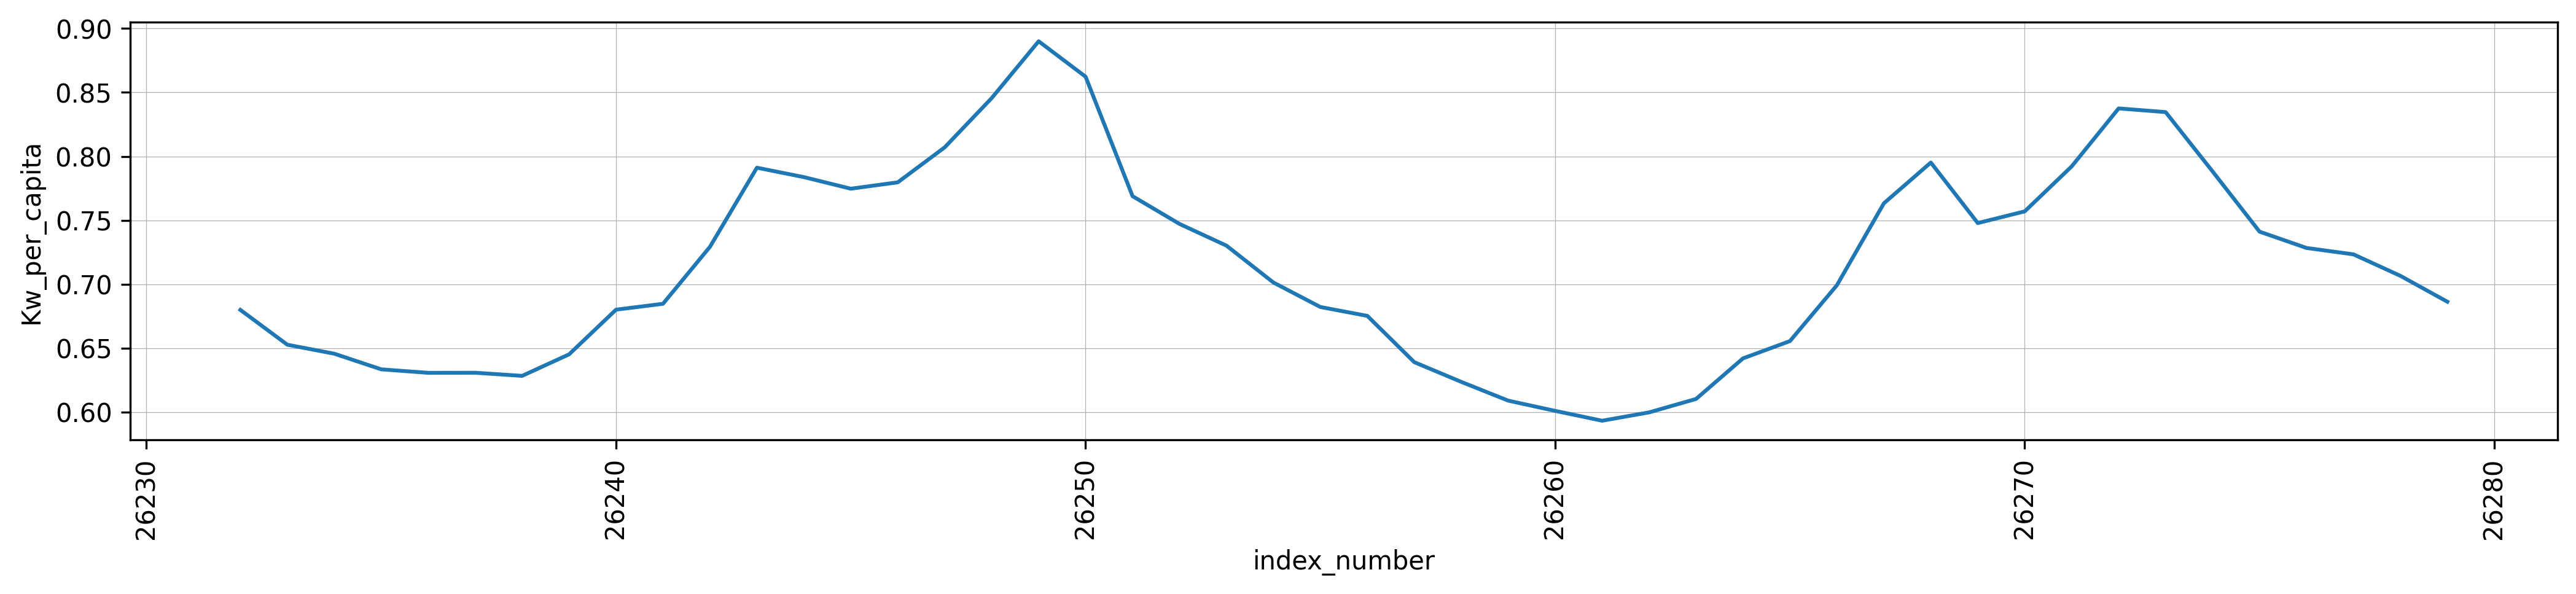

In [92]:
# plot time series
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df1.tail(48), x= 'index_number', y='Kw_per_capita')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
# dfc.keys()

In [93]:
# see if there are any missing values
df1.isna().sum()

index            0
hour             0
lat              0
Temp             0
date             0
weekday          0
Kw_per_capita    0
index_number     0
dtype: int64

## Feature engineering

In [94]:
# count the number of days

total_days = len(df1)/24
print(total_days)

1095.0


In [96]:
# make a copy of df1 for later visualization
df1_v = df1.copy()
df1_v.head()

,index,hour,lat,Temp,date,weekday,Kw_per_capita,index_number
0,26280,0,58.45424,-18.211905,2013-01-01,1,0.586101,0
1,26281,1,58.45424,-18.678336,2013-01-01,1,0.579210,1
2,26282,2,58.45424,-18.978430,2013-01-01,1,0.562302,2
3,26283,3,58.45424,-18.901541,2013-01-01,1,0.555865,3
4,26284,4,58.45424,-19.094290,2013-01-01,1,0.544718,4


In [97]:
# remove further unnecessary features

df1.drop(['index','lat','date','index_number'], axis=1, inplace=True)
df1.head()

,hour,Temp,weekday,Kw_per_capita
0,0,-18.211905,1,0.586101
1,1,-18.678336,1,0.579210
2,2,-18.978430,1,0.562302
3,3,-18.901541,1,0.555865
4,4,-19.094290,1,0.544718


## Train-test split
**Problems:**
- ***we CAN't randomly split a time series with train_test_split(), because the split will randomly select points of time that appear in our train/test data set, which means the time is not continuous, or create gaps in time, this will disrupt the potential correlation exists in a time series.***
- the best to way to train-test split a time series is just take the early 80% as the train data, the following 20% as test data

In [98]:
# determin the train-test split point

split_day = round(total_days*0.8,0)
print(split_day)
split_hour = split_day * 24
print(split_hour)

876.0
21024.0


In [99]:
# train-test split 
train_data = df1[:int(split_hour)]
test_data = df1[int(split_hour):]


In [100]:
# train_data.sample(2)
test_data.sample(2)

,hour,Temp,weekday,Kw_per_capita
21215,23,1.230615,2,0.543578
24101,5,3.337549,4,0.521049


In [101]:
# create input and output variables datasets
X_train = train_data.copy()
X_test = test_data.copy()

y_train = X_train.pop('Kw_per_capita')
y_test = X_test.pop('Kw_per_capita')

# get the values from the dataframe - the result is a numpy array
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

# TODO: explore if we need to construct a DMatrix as the input to XGBoost

train = train = xgb.DMatrix(X_train, label = y_train)  
test = xgb.DMatrix(X_test, label = y_test)

# Reshape the arrays for the predicted variable
# TODO: is this needed here?
y_train = np.reshape(y_train, (-1,1))
y_test = np.reshape(y_test, (-1,1))

In [102]:
# define the MAPE metric
def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [103]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 500, max_depth=2,  seed = 123)
  
# Fitting the model
xgb_r.fit(X_train, y_train)

XGBRegressor(max_depth=2, n_estimators=500, objective='reg:squarederror',
             seed=123)

In [104]:
# Predictions on the train dataset
train_pred = xgb_r.predict(X_train)

# MAE Computation
train_mae = mean_absolute_error(y_train, train_pred)
print("MAE:  % f" %(train_mae))

# RMSE Computation
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print("RMSE: % f" %(train_rmse))

MAE:   0.045169
RMSE:  0.055910


In [105]:
test_pred = xgb_r.predict(X_test)
  
# MAE Computation
test_mae = mean_absolute_error(y_test, test_pred)
print("MAE:  % f" %(test_mae))

# RMSE Computation
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("RMSE : % f" %(test_rmse))

MAE:   0.064356
RMSE :  0.076103


In [106]:
# create predictions dataframe for visualization

len(test_pred)

5256

In [107]:
test_index_number = [i for i in range(int(split_hour),len(df1))]
print(len(test_index_number))
test_index_number[-3:]

5256


[26277, 26278, 26279]

In [108]:
predictions_dict = {'predictions':test_pred, 'test_index':test_index_number}
df_predictions = pd.DataFrame(predictions_dict)
df_predictions.tail()

,predictions,test_index
5251,0.746323,26275
5252,0.738390,26276
5253,0.727494,26277
5254,0.708982,26278
5255,0.669780,26279


In [109]:
# Check the means of the datasets to help interpret the RMSE values

print("Average Kw in the training dataset:  ", train_data['Kw_per_capita'].mean())
print("Average Kw in the test dataset:      ", test_data['Kw_per_capita'].mean())

Average Kw in the training dataset:   0.632209875824591
Average Kw in the test dataset:       0.6288950324054088


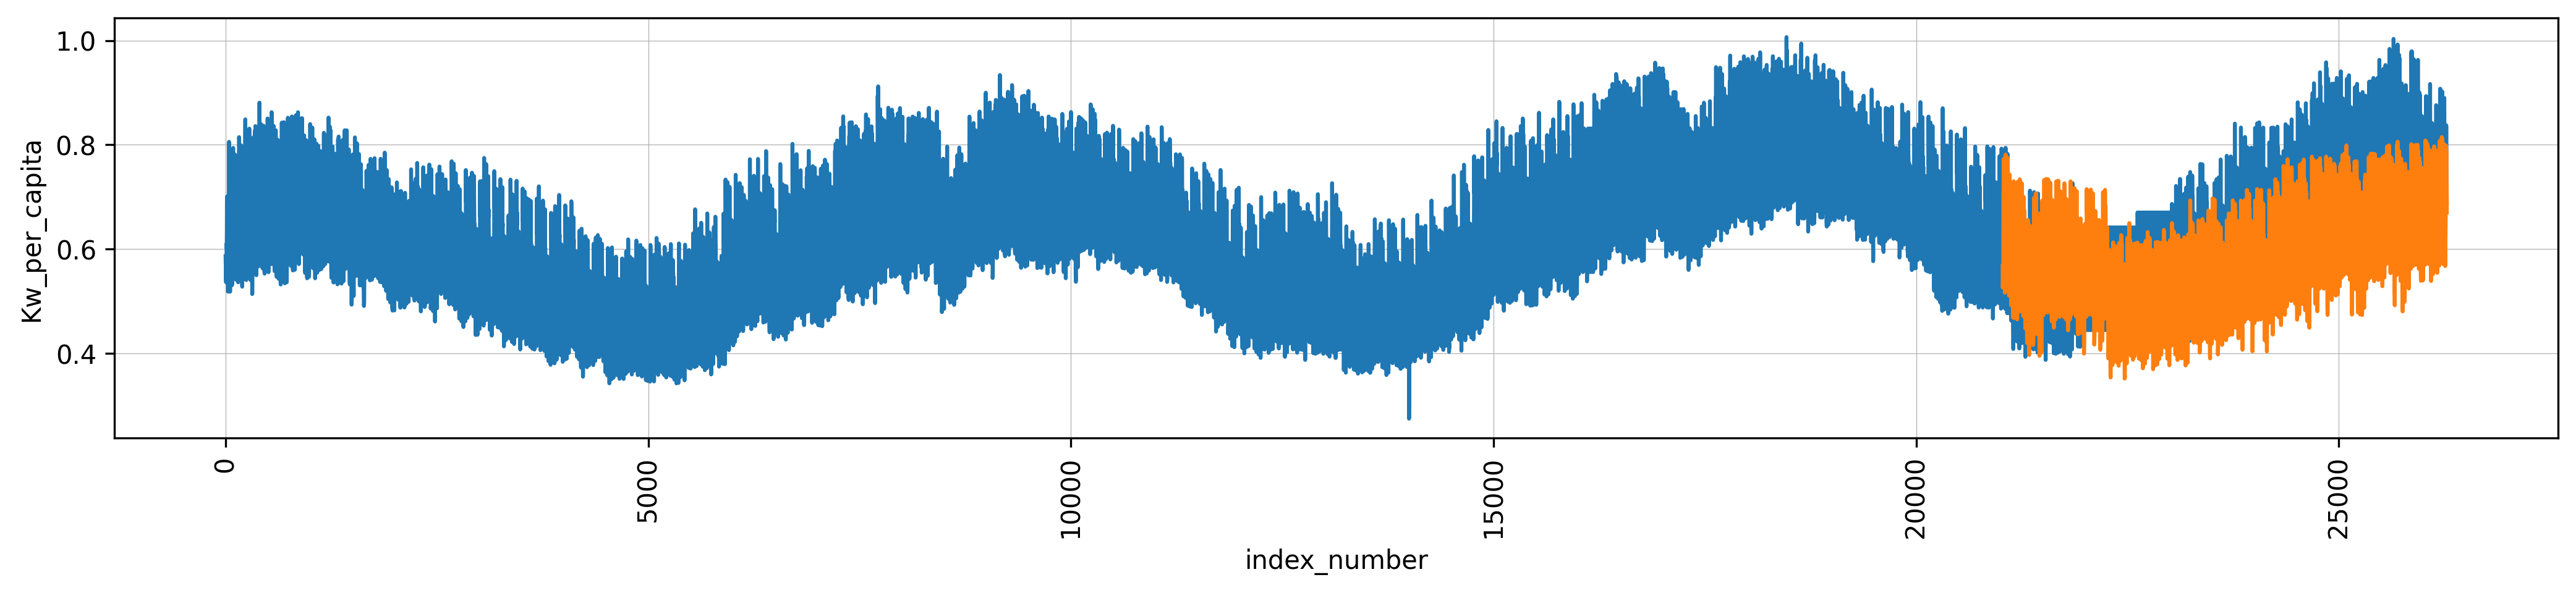

In [110]:
# plot time series
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df1_v, x= 'index_number', y='Kw_per_capita')
sns.lineplot(data=df_predictions, x= 'test_index', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
# dfc.keys()

In [113]:
# Alternative split, only 2 weeks test
split_day2 = total_days - 14
print(split_day2)
split_hour2 = split_day2 * 24
print(split_hour2)

1081.0
25944.0


In [114]:
# train-test split alternative - 2weeks test
train_data2 = df1[:int(split_hour2)]
test_data2 = df1[int(split_hour2):]

In [115]:
# create input and output variables datasets
X_train = train_data2.copy()
X_test = test_data2.copy()

y_train = X_train.pop('Kw_per_capita')
y_test = X_test.pop('Kw_per_capita')

# get the values from the dataframe - the result is a numpy array
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

# TODO: explore if we need to construct a DMatrix as the input to XGBoost

train = train = xgb.DMatrix(X_train, label = y_train)  
test = xgb.DMatrix(X_test, label = y_test)

# Reshape the arrays for the predicted variable
# TODO: is this needed here?
y_train = np.reshape(y_train, (-1,1))
y_test = np.reshape(y_test, (-1,1))

In [116]:
xgb_r2 = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 500, max_depth=2,  seed = 123)
  
# Fitting the model
xgb_r2.fit(X_train, y_train)

XGBRegressor(max_depth=2, n_estimators=500, objective='reg:squarederror',
             seed=123)

In [118]:
# Predictions on the train dataset
train_pred = xgb_r2.predict(X_train)

# MAE Computation
train_mae = mean_absolute_error(y_train, train_pred)
print("MAE:  % f" %(train_mae))

# RMSE Computation
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print("RMSE: % f" %(train_rmse))

MAE:   0.048316
RMSE:  0.059411


In [119]:
test_pred = xgb_r2.predict(X_test)
  
# MAE Computation
test_mae = mean_absolute_error(y_test, test_pred)
print("MAE:  % f" %(test_mae))

# RMSE Computation
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("RMSE : % f" %(test_rmse))

MAE:   0.043345
RMSE :  0.050954


In [120]:
test_index_number = [i for i in range(int(split_hour2),len(df1))]
print(len(test_index_number))
test_index_number[-3:]

336


[26277, 26278, 26279]

In [121]:
predictions_dict = {'predictions':test_pred, 'test_index':test_index_number}
df_predictions = pd.DataFrame(predictions_dict)
df_predictions.tail()

,predictions,test_index
331,0.754265,26275
332,0.745453,26276
333,0.734819,26277
334,0.714520,26278
335,0.673798,26279


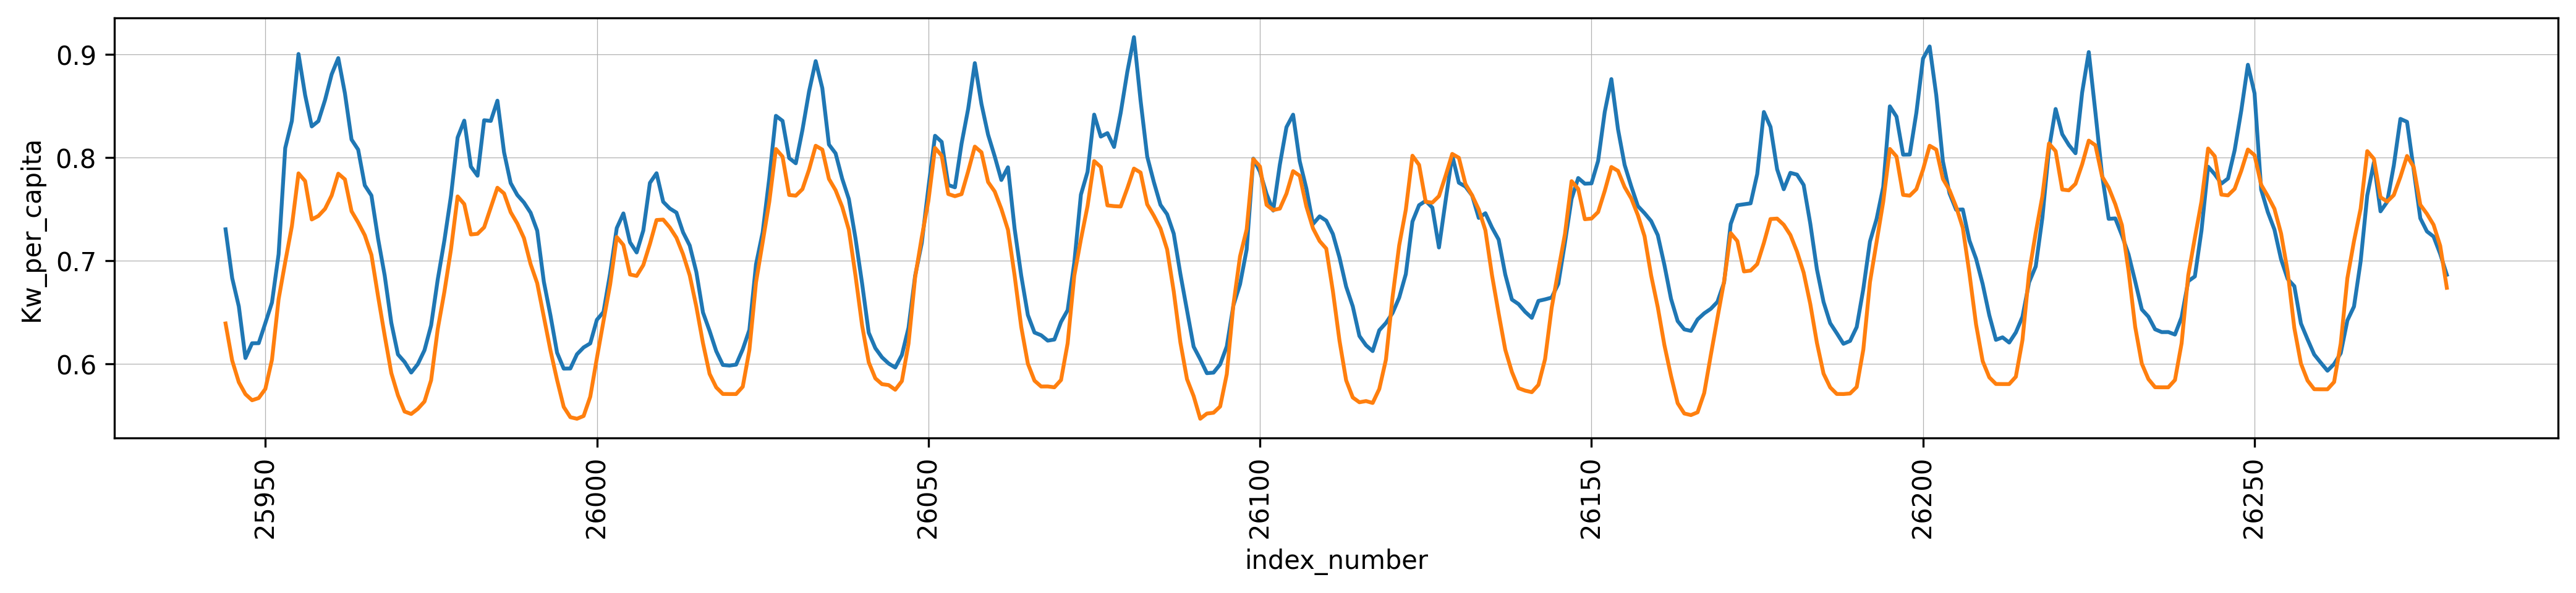

In [123]:
# plot time series
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df1_v[int(split_hour2):], x= 'index_number', y='Kw_per_capita')
sns.lineplot(data=df_predictions, x= 'test_index', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
# dfc.keys()